<a href="https://colab.research.google.com/github/swetzel1/introduction_to_ml/blob/main/project/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Physical Activity Monitoring


In [48]:
#load libraries

import numpy as np
import pandas as pd
import seaborn as sns

from pandas.plotting import scatter_matrix

from imblearn.over_sampling   import SMOTE
from imblearn.under_sampling  import RandomUnderSampler

from matplotlib import pyplot as plt

from joblib import dump, load

from sklearn.preprocessing    import MinMaxScaler
from sklearn.model_selection  import train_test_split
from sklearn.preprocessing    import StandardScaler
from sklearn                  import metrics
from sklearn.decomposition    import PCA
from sklearn.linear_model     import LogisticRegression
from sklearn.naive_bayes      import GaussianNB
from sklearn.ensemble         import RandomForestClassifier
from sklearn.svm              import SVC
from sklearn.metrics          import confusion_matrix
from sklearn.metrics          import ConfusionMatrixDisplay

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [4]:
#folder_structure = '/content/drive/My Drive/Intro_to_ML/final_project/dataset/' #change this to your correspoding folder
folder_structure = '/content/drive/My Drive/final_project/dataset/' #Emilias link

file_names = ['subject101.dat',
              'subject102.dat',
              'subject103.dat',
              'subject104.dat',
              'subject105.dat',
              'subject106.dat',
              'subject107.dat',
              'subject108.dat',
              'subject109.dat' ]

In [5]:
file_names = [folder_structure + name for name in file_names ]

In [6]:
subject_id = [1,2,3,4,5,6,7,8,9]

activity_id_dict = {0: 'transient',
                    1: 'lying',
                    2: 'sitting',
                    3: 'standing',
                    4: 'walking',
                    5: 'running',
                    6: 'cycling',
                    7: 'Nordic_walking',
                    9: 'watching_TV',
                    10: 'computer_work',
                    11: 'car driving',
                    12: 'ascending_stairs',
                    13: 'descending_stairs',
                    16: 'vacuum_cleaning',
                    17: 'ironing',
                    18: 'folding_laundry',
                    19: 'house_cleaning',
                    20: 'playing_soccer',
                    24: 'rope_jumping' }

special_columns = ["timestamp", "activity_id","heartrate"]


imu_hand = ['hand_temperature',
            'hand_Acc6_1',       'hand_Acc6_2',        'hand_Acc6_3',
            'hand_Acc16_1',      'hand_Acc16_2',       'hand_Acc16_3',
            'hand_Gyro1',        'hand_Gyro2',         'hand_Gyro3',
            'hand_Magne1',       'hand_Magne2',        'hand_Magne3',
            'hand_Orientation1', 'hand_Orientation2',  'hand_Orientation3', 'hand_Orientation4']

imu_chest = ['chest_temperature',
             'chest_Acc16_1',       'chest_Acc16_2',      'chest_Acc16_3',
             'chest_Acc6_1',        'chest_Acc6_2',       'chest_Acc6_3',
             'chest_Gyro1',         'chest_Gyro2',        'chest_Gyro3',
             'chest_Magne1',        'chest_Magne2',       'chest_Magne3',
             'chest_Orientation1',  'chest_Orientation2', 'chest_Orientation3', 'chest_Orientation4']

imu_ankle = ['ankle_temperature',
           'ankle_Acc16_1',       'ankle_Acc16_2',      'ankle_Acc16_3',
           'ankle_Acc6_1',        'ankle_Acc6_2',       'ankle_Acc6_3',
           'ankle_Gyro1',         'ankle_Gyro2',        'ankle_Gyro3',
           'ankle_Magne1',        'ankle_Magne2',       'ankle_Magne3',
           'ankle_Orientation1',  'ankle_Orientation2', 'ankle_Orientation3', 'ankle_Orientation4']

columns = special_columns + imu_hand + imu_chest + imu_ankle  #put columns in one list

len(columns)

54

In [7]:
raw_data = pd.DataFrame()
for file in file_names:
    buffer = pd.read_table(file, header=None, sep='\s+')
    buffer.columns = columns #name columns
    buffer['subject_id'] = int(file[-5]) #add subject number to table (from filename)
    raw_data = pd.concat([raw_data, buffer], ignore_index=True)

raw_data.reset_index(drop=True, inplace=True)
raw_data.head()

,timestamp,activity_id,heartrate,hand_temperature,hand_Acc6_1,hand_Acc6_2,hand_Acc6_3,hand_Acc16_1,hand_Acc16_2,hand_Acc16_3,...,ankle_Gyro2,ankle_Gyro3,ankle_Magne1,ankle_Magne2,ankle_Magne3,ankle_Orientation1,ankle_Orientation2,ankle_Orientation3,ankle_Orientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1


## Data Cleaning

Additional files that come with the dataset explain how the data was gathered and give information on which parts of the data can be used.

* remove transient activity(id == 0), no usefull data
* remove columns 'Orientation' --> not used in information gathering
* remove columns 'accelerometer 6g' --> was not precicly calibrated during the data aquisition

* remove subject 9

* remove timestamp, since it doesnt contain any meaningful information correlated to the activity performed at the time

* remove subject id

* interpolate missing values due to:
  * different frequencies (heartrate sensor - 9Hz, IMUs 100Hz)
  * connection lost, package drops in wireless transmission



In [8]:
data = raw_data.drop(['hand_Orientation1',   'hand_Orientation2',  'hand_Orientation3',  'hand_Orientation4',
                      'chest_Orientation1',  'chest_Orientation2', 'chest_Orientation3', 'chest_Orientation4',
                      'ankle_Orientation1',  'ankle_Orientation2', 'ankle_Orientation3', 'ankle_Orientation4'],
                    axis = 1)  # removal of orientation columns

data = data.drop(['hand_Acc6_1',  'hand_Acc6_2',   'hand_Acc6_3',
                  'chest_Acc6_1', 'chest_Acc6_2',  'chest_Acc6_3',
                  'ankle_Acc6_1', 'ankle_Acc6_2',  'ankle_Acc6_3',],
                    axis = 1) # remove columns of accelerometer6g

data = data.drop(data[data.subject_id == 9].index) #(maybe not even load in first place ...)

In [9]:
#linear interpolation - think about other/better methods
data = data.interpolate() #interpolate before transient activity gets removed

In [10]:
data = data.drop(data[data.activity_id == 0].index) #remove any row of activity 0 (transient)

data = data.drop(['timestamp', 'subject_id'], axis = 1)

#remove all activities which only one person did
data = data.drop(data[data.activity_id == 9].index)  #remove watching TV
data = data.drop(data[data.activity_id == 9].index)  #remove car driving
data = data.drop(data[data.activity_id == 9].index)  #remove playing soccer

In [11]:
data.reset_index(drop = True, inplace = True)
data.head()

,activity_id,heartrate,hand_temperature,hand_Acc16_1,hand_Acc16_2,hand_Acc16_3,hand_Gyro1,hand_Gyro2,hand_Gyro3,hand_Magne1,...,ankle_temperature,ankle_Acc16_1,ankle_Acc16_2,ankle_Acc16_3,ankle_Gyro1,ankle_Gyro2,ankle_Gyro3,ankle_Magne1,ankle_Magne2,ankle_Magne3
0,1,100.0,30.375,2.24689,8.55387,5.77143,-0.004750,0.037579,-0.011145,8.93200,...,30.75,9.73855,-1.84761,0.095156,0.002908,-0.027714,0.001752,-61.1081,-36.8636,-58.3696
1,1,100.0,30.375,2.27373,8.14592,5.78739,-0.171710,0.025479,-0.009538,9.58300,...,30.75,9.69762,-1.88438,-0.020804,0.020882,0.000945,0.006007,-60.8916,-36.3197,-58.3656
2,1,100.0,30.375,2.26966,7.66268,5.78846,-0.238241,0.011214,0.000831,9.05516,...,30.75,9.69633,-1.92203,-0.059173,-0.035392,-0.052422,-0.004882,-60.3407,-35.7842,-58.6119
3,1,100.0,30.375,2.22177,7.25535,5.88000,-0.192912,0.019053,0.013374,9.92698,...,30.75,9.66370,-1.84714,0.094385,-0.032514,-0.018844,0.026950,-60.7646,-37.1028,-57.8799
4,1,100.0,30.375,2.20720,7.24042,5.95555,-0.069961,-0.018328,0.004582,9.15626,...,30.75,9.77578,-1.88582,0.095775,0.001351,-0.048878,-0.006328,-60.2040,-37.1225,-57.8847


In [12]:
data.isnull().sum() #check for missing values left after interpolation

activity_id          0
heartrate            0
hand_temperature     0
hand_Acc16_1         0
hand_Acc16_2         0
hand_Acc16_3         0
hand_Gyro1           0
hand_Gyro2           0
hand_Gyro3           0
hand_Magne1          0
hand_Magne2          0
hand_Magne3          0
chest_temperature    0
chest_Acc16_1        0
chest_Acc16_2        0
chest_Acc16_3        0
chest_Gyro1          0
chest_Gyro2          0
chest_Gyro3          0
chest_Magne1         0
chest_Magne2         0
chest_Magne3         0
ankle_temperature    0
ankle_Acc16_1        0
ankle_Acc16_2        0
ankle_Acc16_3        0
ankle_Gyro1          0
ankle_Gyro2          0
ankle_Gyro3          0
ankle_Magne1         0
ankle_Magne2         0
ankle_Magne3         0
dtype: int64

## Visualization



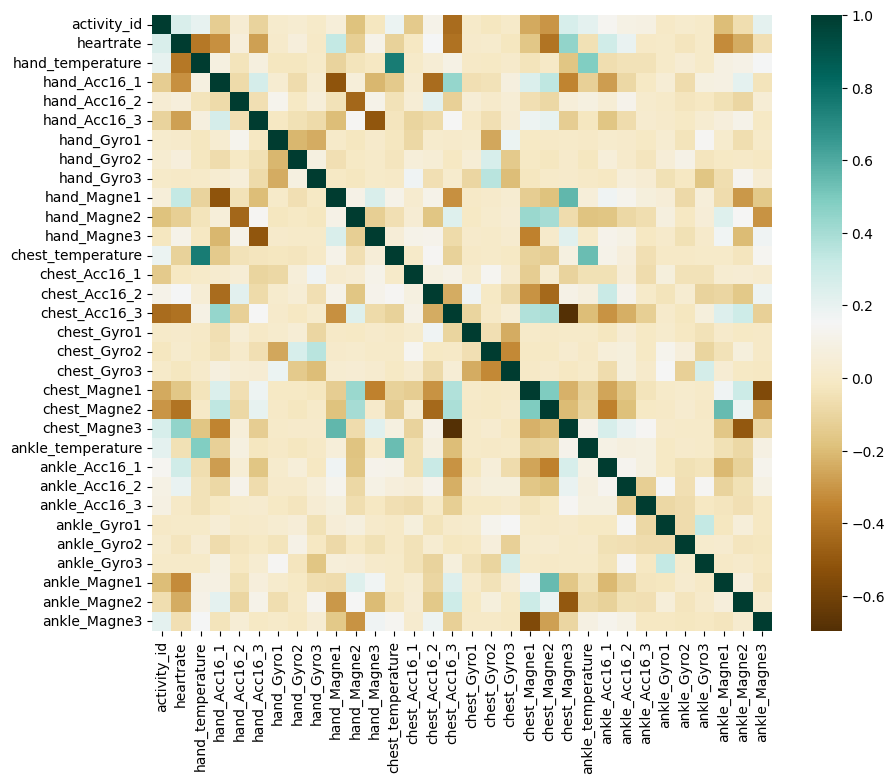

In [ ]:
#correlation heat map

df_corr = data.corr()
f, ax = plt.subplots(figsize=(10, 8))


#creat mask to find features with weak explanatory strenght
#mask = (np.abs(df_corr) <= 0.1)
#--> gyroscope does not seem to have relevant information

#sns.heatmap(df_corr, cmap = "BrBG",ax=ax, mask=mask)
sns.heatmap(df_corr, cmap = "BrBG",ax=ax)

plt.show()

Guess:
The **Gyroscope** does seem to have weak correlation with everything
* try training without gyro

--> Training without gyro led to significantly worse performance (see confusion matrix)

In [ ]:
#drop gyroscope data

'''
data = data.drop(['hand_Gyro1',  'hand_Gyro2',  'hand_Gyro3',
                  'chest_Gyro1', 'chest_Gyro2', 'chest_Gyro3',
                  'ankle_Gyro1', 'ankle_Gyro2', 'ankle_Gyro3'
                  ], axis = 1)

data.reset_index(drop = True, inplace = True)
'''

"\ndata = data.drop(['hand_Gyro1',  'hand_Gyro2',  'hand_Gyro3',\n                  'chest_Gyro1', 'chest_Gyro2', 'chest_Gyro3',\n                  'ankle_Gyro1', 'ankle_Gyro2', 'ankle_Gyro3'\n                  ], axis = 1)\n\ndata.reset_index(drop = True, inplace = True)\n"

## Data Distribution

<Axes: >

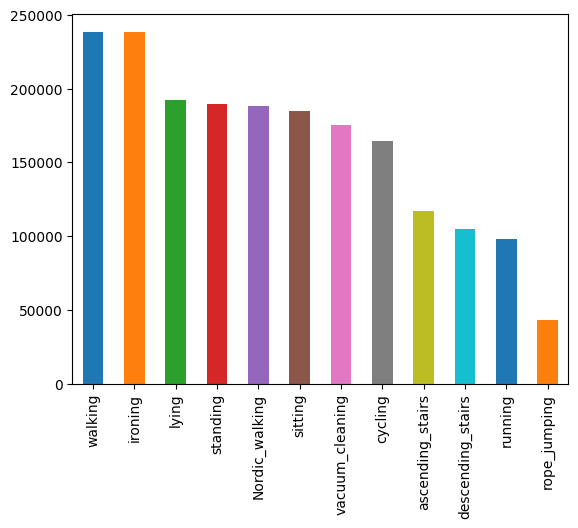

In [13]:
class_distribution = data['activity_id'].value_counts()

class_distribution.index = class_distribution.index.map(activity_id_dict)
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
class_distribution.plot(kind='bar', color=c)

The distribution over the classes is imbalanced.
* up and downsample some of the classes to balance the datas

In [14]:
#split for resampling

col = data.columns
x_cols = col[1:]


y_df = data['activity_id']
x_df = data[x_cols]

In [18]:
class_distribution

walking              238761
ironing              238690
lying                192523
standing             189931
Nordic_walking       188107
sitting              185188
vacuum_cleaning      175353
cycling              164600
ascending_stairs     117216
descending_stairs    104944
running               98199
rope_jumping          42969
Name: activity_id, dtype: int64

In [ ]:
#naive resampling --> random undersampling --> deleting random samples of the majority class

#brings everything to size of cycling
undersample_dict = {4 :164600,
                   17 :164600,
                    1 :164600,
                    3 :164600,
                    7 :164600,
                    2 :164600,
                   16 :164600}

undersampler = RandomUnderSampler(sampling_strategy=undersample_dict, random_state=100)
data_resampled, y_res = undersampler.fit_resample(x_df, y_df) #takes really long



#upsample the other actvities
# ascending_stairs, descending_stairs, running, rope_jumping
oversample_dict = {12 : 164600,
                   13 : 164600,
                    5 : 164600,
                   24 : 164600}

#oversample data using SMOTE
sm = SMOTE(sampling_strategy=oversample_dict, random_state=100)
data_resampled, y_res = sm.fit_resample(data_resampled, y_res) #takes really long


data_resampled['activity_id'] = y_res #put back together
#data_resampled.head()

In [21]:
class_distribution = data_resampled['activity_id'].value_counts()

class_distribution.index = class_distribution.index.map(activity_id_dict)
class_distribution

lying                164600
sitting              164600
standing             164600
walking              164600
running              164600
cycling              164600
Nordic_walking       164600
ascending_stairs     164600
descending_stairs    164600
vacuum_cleaning      164600
ironing              164600
rope_jumping         164600
Name: activity_id, dtype: int64

## Scale, Randomize, Split

In [22]:
#Scale
col = data.columns
columns_to_scale = col[1:] #everything but labels
scaled_data = data_resampled #make copy

#Choose Scaling Approach
scaler = MinMaxScaler() #way better results than standardscaler

# apply scaler
scaled_data[columns_to_scale] = scaler.fit_transform(data_resampled[columns_to_scale])

In [23]:
'''
# use this paragraph, to train with unbalanced data !!!

col = data.columns
columns_to_scale = col[1:] #everything but labels
scaled_data = data

scaler = MinMaxScaler() #way better results than standardscaler
# apply scaler
scaled_data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
'''

'\n# use this paragraph, to train with unbalanced data !!!\n\ncol = data.columns\ncolumns_to_scale = col[1:] #everything but labels\nscaled_data = data\n\nscaler = MinMaxScaler() #way better results than standardscaler\n# apply scaler\nscaled_data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])\n'

In [24]:
#split 80/20 and randomize

df_train, df_val = train_test_split(scaled_data, train_size = 0.8, test_size = 0.2, random_state = 100)

In [25]:
# seperate x from y
y_train = df_train.pop('activity_id')
y_val   = df_val.pop('activity_id')

# convert to numpy array
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

x_train = df_train.to_numpy()
x_val = df_val.to_numpy()

In [26]:
x_train.shape

(1580160, 31)

In [42]:
#PCA
k = 15 #optimal value to be found
pca = PCA(n_components=k)

pc_train = pca.fit_transform(x_train)
pc_val = pca.fit_transform(x_val)

## Classifiers

In [50]:
#Logistic Regression

clf = LogisticRegression(solver='saga', penalty="l2", max_iter=300) #try different solvers and penalties
clf.fit(pc_train, y_train)
y_pred = clf.predict(pc_val)

In [46]:
#Naive Bayesianx

#clf = GaussianNB()
#clf.fit(pc_train, y_train)
#y_pred = clf.predict(pc_val)

## Evaluation

Text(0.5, 47.5815972222222, 'Predicted label')

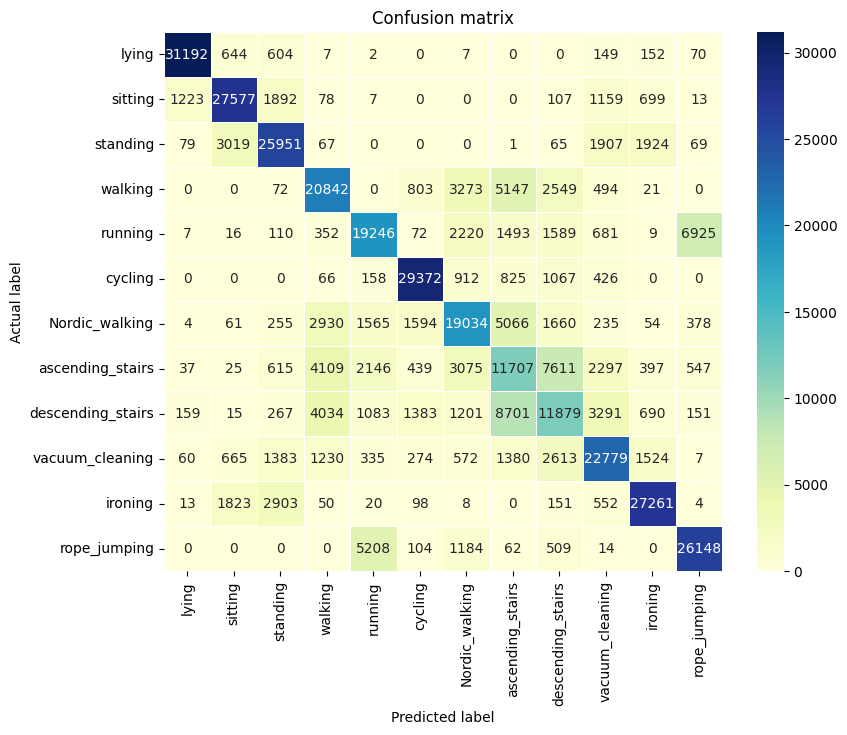

In [68]:
#confusion matrix
cnf_matrix = confusion_matrix(y_val, y_pred)

class_labels = np.vectorize(activity_id_dict.get)(clf.classes_)

# create heatmap
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g',linewidths=0.5,  xticklabels=class_labels, yticklabels=class_labels, ax=ax)

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [56]:
recall = np.diag(cnf_matrix) / np.sum(cnf_matrix, axis = 1)
precision = np.diag(cnf_matrix) / np.sum(cnf_matrix, axis = 0)

#np.mean(recall)
#np.mean(precision)

array([0.95173003, 0.81480278, 0.76209914, 0.6172664 , 0.64648975,
       0.86036498, 0.60452264, 0.34049793, 0.39862416, 0.67028602,
       0.83288014, 0.76206575])

In [66]:
f1_score = (2*recall*precision) / (recall+precision)

In [67]:
d = {'activity':class_labels, 'precision':precision, 'recall':recall, 'f1-score':f1_score}
performance = pd.DataFrame(data = d)
performance

,activity,precision,recall,f1-score
0,lying,0.951730,0.950193,0.950961
1,sitting,0.814803,0.841917,0.828138
2,standing,0.762099,0.784445,0.773110
3,walking,0.617266,0.627752,0.622465
4,running,0.646490,0.588203,0.615971
5,cycling,0.860365,0.894779,0.877234
6,Nordic_walking,0.604523,0.579669,0.591835
7,ascending_stairs,0.340498,0.354704,0.347456
8,descending_stairs,0.398624,0.361569,0.379194
9,vacuum_cleaning,0.670286,0.694016,0.681945


In [40]:
'''
#store model in file
path = '/content/drive/My Drive/final_project/models/'
model_name = 'up_and_down_sampled.joblib'
model_path = path+model_name

dump(clf, model_path)
'''

"\n#store model in file\npath = '/content/drive/My Drive/final_project/models/'\nmodel_name = 'up_and_down_sampled.joblib'\nmodel_path = path+model_name\n\ndump(clf, model_path)\n"

In [41]:
'''

#load model from file
path = '/content/drive/My Drive/final_project/models/'
model_name = 'without_gyro.joblib'
model_path = path+model_name

clf = load(model_path)
y_pred = clf.predict(pc_val)

'''

"\n\n#load model from file\npath = '/content/drive/My Drive/final_project/models/'\nmodel_name = 'without_gyro.joblib'\nmodel_path = path+model_name\n\nclf = load(model_path)\ny_pred = clf.predict(pc_val)\n\n"